In [1]:
%config Completer.use_jedi = False

In [1]:
# arrays
import numpy as np
import xarray as xr
# plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# tide
import utide

In [4]:

# basics
import os, sys

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

from sscode.mda import maxdiss_simplified_no_threshold as MDA

In [5]:
from sscode.data import load_moana_hindcast

In [20]:
mda_data = load_moana_hindcast().isel(site=10).dropna(dim='time').load()[['msea','ss','tide']]\
    .to_dataframe().drop(columns=['site']).values


 loading the Moana v2 hindcast data... 



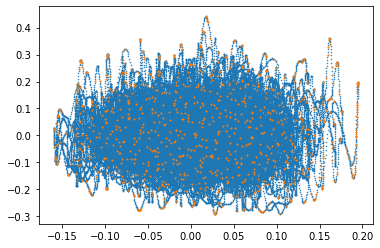

In [33]:
plt.plot(mda_data[:,0],mda_data[:,1],'.',markersize=1)
plt.plot(data[:,0],data[:,1],'.',markersize=2)

In [32]:
data = MDA(mda_data,1000,[0,1,2],[],log=True)

MDA: dataset 194851 centroids: 1000/1000



In [3]:
nino = xr.open_dataset('../data/indexes/nino34Mon.nc')

In [4]:
nino

<xarray.Dataset>
Dimensions:  (ENS: 41, LAT: 1, LEVEL: 1, LON: 1, TIME: 21)
Coordinates:
  * ENS      (ENS) int32 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40 41
  * TIME     (TIME) datetime64[ns] 2020-05-01 2020-06-01 ... 2022-01-01
  * LEVEL    (LEVEL) int32 1
  * LAT      (LAT) float32 0.0
  * LON      (LON) float32 0.0
Data variables:
    anom     (ENS, TIME, LEVEL, LAT, LON) float32 ...
Attributes:
    title:       CPC CFSv2 Climate Forecast Monitoring
    summary:     coverted from binary format for image
    image_file:  nino34Mon.gif
    history:     created: Tue 11 May 2021 09:31:45 PM UTC

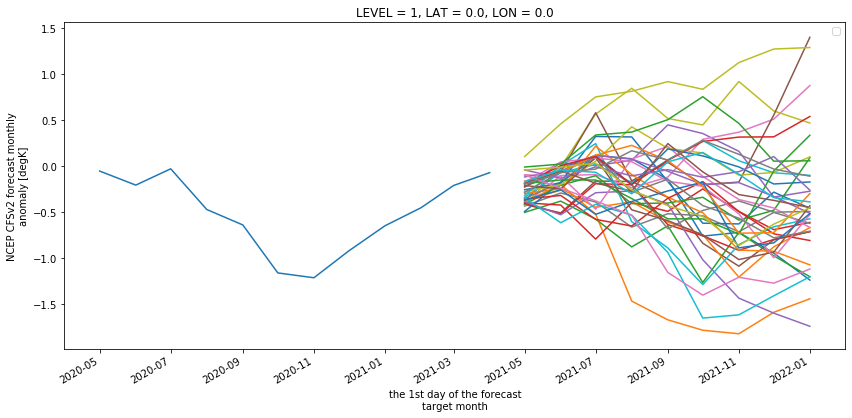

In [5]:
nino.anom.plot(hue='ENS',figsize=(14,6))
plt.legend('')

In [6]:
data = xr.open_mfdataset('../data/indexes/glbPrecSea.nc')

/home/javitausia/miniconda3/envs/plotdash/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/javitausia/miniconda3/envs/plotdash/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [7]:
data

<xarray.Dataset>
Dimensions:  (ENS: 1, LAT: 190, LEVEL: 1, LON: 384, TIME: 6)
Coordinates:
  * ENS      (ENS) int32 1
  * TIME     (TIME) datetime64[ns] 2021-05-01 2021-06-01 ... 2021-10-01
  * LEVEL    (LEVEL) int32 1
  * LAT      (LAT) float32 -89.2766 -88.3398 -87.3973 ... 88.3398 89.2766
  * LON      (LON) float32 0.0 0.9375 1.875 2.8125 ... 357.1875 358.125 359.0625
Data variables:
    anom     (ENS, TIME, LEVEL, LAT, LON) float32 dask.array<chunksize=(1, 6, 1, 190, 384), meta=np.ndarray>
Attributes:
    title:       CPC CFSv2 Climate Forecast Monitoring
    summary:     coverted from binary format for image
    image_file:  glbPrecSea.gif
    history:     created: Tue 11 May 2021 09:32:02 PM UTC

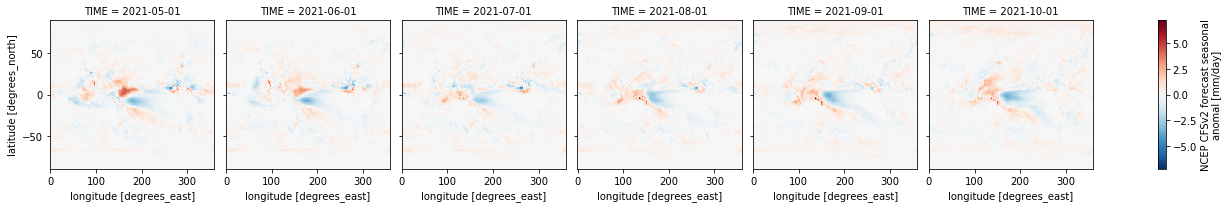

In [8]:
data.isel(ENS=0,LEVEL=0).anom.plot(col='TIME')

In [13]:
# minutal tidal gauges
tgdata = xr.open_dataset('../data/storm_surge_data/nz_tidal_gauges/other/raw/LittleKaiteriteri_all.nc')

In [14]:
tgdata

<xarray.Dataset>
Dimensions:  (time: 2029798)
Coordinates:
  * time     (time) datetime64[ns] 2000-06-16T04:05:00 ... 2021-02-25T01:00:00
Data variables:
    elev     (time) float32 ...
Attributes:
    data_onwer:  Tasman Regional Council

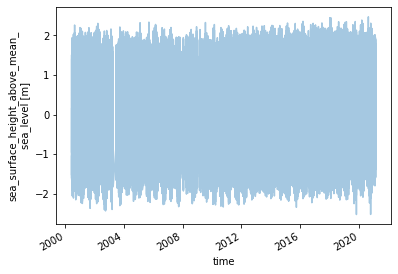

In [15]:
tgdata.elev.plot(alpha=0.4)

In [69]:
# fft test
tgfft = xr.open_dataset('../data/storm_surge_data/nz_tidal_gauges/linz/raw/CHST_raw.nc')\
    .elev[0,:].sel(time='2018')

In [70]:
tgfft

<xarray.DataArray 'elev' (time: 523085)>
[523085 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:53:00
    sensor   int64 40
Attributes:
    standard_name:  sea_surface_height_above_reference_ellipsoid
    units:          m

In [71]:
# delete tide
time = mdates.date2num(tgfft.time.values)
coef = utide.solve(time, tgfft.values,lat=-44,method='ols',conf_int='MC')
tide = utide.reconstruct(time, coef)

solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.


In [72]:
tgfft = tgfft.to_dataset(name='elev').assign({'tide':(('time'),tide['h'])})

In [73]:
tgfft['ss'] = tgfft.elev-tgfft.tide

In [74]:
tgfft.sel(time='2018-02-20')

<xarray.Dataset>
Dimensions:  (time: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2018-02-20 ... 2018-02-20T23:59:00
    sensor   int64 40
Data variables:
    elev     (time) float32 3.5690002 3.5730002 ... 3.0080001 3.0340002
    tide     (time) float64 3.356 3.363 3.37 3.378 ... 2.903 2.913 2.922 2.931
    ss       (time) float64 0.2132 0.2099 0.2026 ... 0.1895 0.08615 0.1028

In [75]:
# crop to storm
tgfft_storm = tgfft.sel(time='2018-02-20')

/home/javitausia/miniconda3/envs/plotdash/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


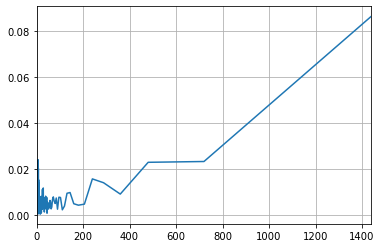

In [81]:
def freq_to_day(values):
    return (1.0/values)/(60)

# number of sample points
N = len(tgfft_storm.time.values)
# sample spacing
T = 60.0 # seconds
y = tgfft_storm.ss.values
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
xf = freq_to_day(xf)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
#plt.xlim(freq_to_day(0.00001),freq_to_day(0.00004))
plt.xlim(0,60*24)
plt.show()